<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/period-and-revolution-time-rigid-pendulum-ChaseAdamson/blob/main/extract_period_int_ode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad

Define ODE function as well as integrand functions. The ODE function will numerically solve the rigid pendulum and the integrand functions will be used later in order to find the period in the oscillatory domain and the revolving domain.

In [2]:
# rigid pendulum ODE and integrand

# rigid pendulum ODE
def rigid_pendulum_ode(t, y, omega_0=1):
  theta, ang_vel = y # unpacking state variable
  dtheta_dt = ang_vel # defining first derivative
  d2theta_dt2 = -omega_0**2*np.sin(theta) # defining second derivative
  dy_dt = [dtheta_dt, d2theta_dt2] # defining derivative of state variable
  return dy_dt

# define the integrand for the oscillation period
def oscillation_integrand(theta, ang_vel_0, omega_0=1): # 2w_0 = threshold ang_vel
    coeff = 4 # leading coefficient of the integrand
    denominator = np.sqrt(ang_vel_0**2-2*omega_0**2*(1-np.cos(theta))) # denominator of integrand
    return coeff/denominator

# define integrand for revolution period
def revolution_integrand(theta, ang_vel_0, omega_0=1):
  coeff = 2
  denominator = np.sqrt(ang_vel_0**2-2*omega_0**2*(1-np.cos(theta)))
  return coeff/denominator

Create Utilities. The plotting utility will be used to plot the periods against the intial angular velocities. The event functions will detect events marking periods for the two domains. For the oscillation domain, the event is when the angular velocity goes from negative to positive. For the revolving domain, the event is when the angle is equal to pi + 2n*pi for an arbitrary integer n. The extract period functions extract the periods by two different methods, integration and solve_ivp events. The integration function uses the appropriate integrand based on the domain, and the ode function uses the appropriate events based on the domain.

In [3]:
# utilities

# plotting
def basic_plot(x, y, xlabel=None, ylabel=None, figsize=(3,3)):
  plt.figure(figsize=figsize)
  plt.plot(x, y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  return plt.show()

# define the event function for oscillatory motion: ang_vel = 0
def ang_vel_zero_event(t, y, omega_0=1):
  """
  Parameters:
  t: time in seconds
  y: state of pendulum (theta, angular velocity)
  omega_0: natural frequency of pendulum = 1

  This function returns the angular velocity of the pendulum.
  """
  theta, ang_vel = y # unpack state variable
  return ang_vel # set to find values where ang_vel = 0

# add required attributes to the event function
ang_vel_zero_event.terminal = False # continue integrating after events are detected
ang_vel_zero_event.direction = -1 # zeros are from + to -

# Define event function for revolving motion: theta=0
def theta_zero_event(t, y, omega_0=1):
  """
  Parameters:
  t: time in seconds
  y: state of the pendulum (theta, angular velocity)
  omega_0: natural frequency of pendulum = 1

  This function returns the angle of the pendulum bound between -pi and pi.
  """
  theta, ang_vel = y #unpack state variable
  return np.mod(theta, 2*np.pi)-np.pi # set to find values where theta - pi = 0
theta_zero_event.terminal = False # keep integrating after event(s) are found
theta_zero_event.direction = 1 # track zeros when going from negative to positive


# extract period on mesh of ang_vel_0 values
def extract_period_int(n_points, eps=1e-3, omega_0=1):
  """
  Parameters:
  n_points: The number of inital angular velocity values for which integration will be done to determine the period
  eps: The distance between 0 and the first point which must exist to avoid a divergent period
  omega_0: The natural frequency of the pendulum = 1

  This function creates a list of initial angular velocities and based on whether these angular velocities
  surpass the threshold between oscillatory and revolving motion, the function integrates the appropriate integrand with the given
  initial angular velocity while avoiding ang_vel_0 values too close to the threshold which result in a divergent period.
  This function mirrors the list of periods because the symmetry of the system makes this possible.
  This function then returns the list of initial angular velocities and the corresponding list of periods.
  """

  # extract period with integral on a list of initial angular velocities
  ang_vel_0_list = np.linspace(eps, np.pi-eps, n_points)

  threshold_ang_vel=2*omega_0 # separates oscillation from revolution
  period_list_int = [] # initialize list of periods
  for ang_vel_0 in ang_vel_0_list:
    if ang_vel_0 < threshold_ang_vel-eps: # if the motion is oscillatory
      theta_max=np.arccos(1-(1/2)*(ang_vel_0/omega_0)**2) # maximum angle given initial angular velocity
      period, err = quad(oscillation_integrand, 0, theta_max, args=(ang_vel_0, omega_0))
    elif threshold_ang_vel - eps <= ang_vel_0 <= threshold_ang_vel + eps:
      period = np.nan
    else: # if motion is revolving
      period, err = quad(revolution_integrand, 0, np.pi, args=(ang_vel_0, omega_0))
    period_list_int.append(period)

  period_list_int = np.array(period_list_int) # convert to a numpy array

  period_list_int = np.concatenate([period_list_int[::-1], period_list_int]) # enforcing symmetry to mirror data about 0
  ang_vel_0_list = np.concatenate([-ang_vel_0_list[::-1], ang_vel_0_list]) # enforcing symmetry to mirror data about 0
  return ang_vel_0_list, period_list_int


# extract period with solve_ivp events
def extract_period_ode(n_points, eps=1e-3, omega_0=1):
  """
  Parameters:
  n_points: The number of inital angular velocity values for which integration will be done to determine the period
  eps: The distance between 0 and the first point which must exist to avoid a divergent period
  omega_0: The natural frequency of the pendulum = 1

  This function creates a list of initial angular velocities and based on whether these angular velocities
  surpass the threshold between oscillatory and revolving motion, the function detects the events marking the period's completion
  by solving the ode numerically. This function solves the ode from t=0 to t=100 and averages the values of the
  periods to find a mean period while avoiding the divergent period at ang_vel_0 = 2*omega_0.
  This function mirrors the list of periods because the symmetry of the system makes this possible.
  This function then returns the list of initial angular velocities and the corresponding list of periods.
  """
  ang_vel_0_list = np.linspace(eps, np.pi-eps, n_points) # list of initial angular velocity values

  # range of times for integration
  t_min = 0
  t_max = 100
  t_span = [t_min, t_max] # time span for solve_ivp

  threshold_ang_vel=2*omega_0 # separates oscillation from revolution
  period_list_ode = [] # initializes list of periods
  for ang_vel_0 in ang_vel_0_list:
    # define state variable for run
    y_0 = [0, ang_vel_0] # initial condition
    if ang_vel_0 < threshold_ang_vel - eps: # if motion is oscillatory
      # solve differential equation
      sol = solve_ivp(rigid_pendulum_ode, t_span, y_0, args=(omega_0,),
                      max_step = 0.01,
                      dense_output=False,
                      events=ang_vel_zero_event # events are inflection points
                      )
      period = (np.mean(np.diff(sol.t_events[0])) if (len(sol.t_events) > 0 and len(sol.t_events[0]) >= 2) else np.nan)

    elif threshold_ang_vel - eps <= ang_vel_0 <= threshold_ang_vel + eps:
      period = np.nan # period diverges near threshold ang_vel_0

    else: # if motion is revolving
      # solve differential equation
      sol = solve_ivp(rigid_pendulum_ode, t_span, y_0, args=(omega_0,),
                      max_step = 0.01,
                      dense_output=False,
                      events=theta_zero_event # events are revolutions
                      )
      period = (np.mean(np.diff(sol.t_events[0])) if (len(sol.t_events) > 0 and len(sol.t_events[0]) >= 2) else np.nan)
    # output extracted period
    period_list_ode.append(period) # append the period

  period_list_ode = np.array(period_list_ode) # make into a numpy array

  period_list_ode = np.concatenate([period_list_ode[::-1], period_list_ode]) # enforces symmetry to mirror data around 0
  ang_vel_0_list = np.concatenate([-ang_vel_0_list[::-1], ang_vel_0_list]) # enforces symmetry to mirror data around 0
  return ang_vel_0_list, period_list_ode

Call both methods of extracting the period.

In [4]:
# extract period with the integral approach
n_points_int = 100 # number of initial angular velocities
ang_vel_0_list_int, period_list_int = extract_period_int(n_points_int) # extract period on mesh of ang_vel_0

# extract the period with the solve_ivp approach
n_points_ode = 20 # number of initial angular velocities
ang_vel_0_list_ode, period_list_ode = extract_period_ode(n_points_ode) # extract period on mesh of ang_vel_0

/tmp/ipython-input-639680799.py:67: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  period, err = quad(oscillation_integrand, 0, theta_max, args=(ang_vel_0, omega_0))


Plot the periods against initial angular velocity. Plot the two methods of extracting the periods against each other on both the oscillation domain and the revolution domain. If they overlap, this is good evidence the solution is working properly.

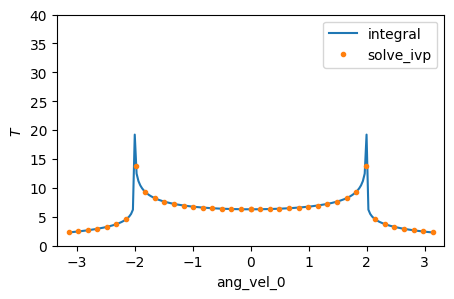

In [5]:
# plot them together
plt.figure(figsize=(5,3))
plt.plot(ang_vel_0_list_int, period_list_int, label='integral')
plt.plot(ang_vel_0_list_ode, period_list_ode, '.', label='solve_ivp')
plt.xlabel('ang_vel_0')
plt.ylabel('$T$')
plt.xlim(-np.pi-0.2, np.pi+0.2)
plt.ylim(0, 40)
plt.legend()
plt.show()